# Set Up

In [ ]:
from nltk import ngrams
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize

# !pip3 install pytorch-nlp
# from torchnlp.word_to_vector import GloVe
# glove = GloVe(name='6B', dim='50')
from tqdm.notebook import tqdm
import numpy as np
import re

if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu"  
device = torch.device(dev)
print(device)
torch.manual_seed(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda:0


# Download Data

In [ ]:
!wget https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
!tar -xf books1.tar.gz
path = 'books1/epubtxt/'
selected_book = 'crocodiles-spirit.epub.txt'

--2021-05-06 16:02:07--  https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
Resolving the-eye.eu (the-eye.eu)... 162.213.130.242
Connecting to the-eye.eu (the-eye.eu)|162.213.130.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2404269430 (2.2G) [application/octet-stream]
Saving to: ‘books1.tar.gz’

books1.tar.gz       100%[===================>]   2.24G  23.9MB/s    in 28s     

2021-05-06 16:02:37 (81.3 MB/s) - ‘books1.tar.gz’ saved [2404269430/2404269430]



## Parameters


In [ ]:
SENT_START = "<s>"
SENT_END   = "</s>"
SENT_UNK   = "<unk>"
SENT_PAD   = "<pad>"

EMBED_SIZE = 50
LSTM_HIDEN_SIZE = 100
BATCH_SIZE = 2

# Preprocessing


In [ ]:
class Dictionary():
    def __init__(self, words=None, th=10):
        self.sent_start  = SENT_START
        self.sent_end    = SENT_END
        self.unk         = SENT_UNK
        self.pad         = SENT_PAD
        if not words is None:
            self.fit(words, th)

    def calc_wordfreqs(self):
        self.wordfreqs   = {}
        for word in self.words:
            if word in self.wordfreqs:
                self.wordfreqs[word] += 1
            else:
                self.wordfreqs[word]  = 1
    
    def set_vocabs(self, th):
        self.vocabs = set([self.pad,self.sent_start, self.sent_end, self.unk])
        for word in self.words:
            if self.wordfreqs[word] >= th:
                self.vocabs.add(word)

    def set_idx_word_map(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        for idx, word in enumerate(self.vocabs):
            self.idx_to_word[idx] = word
            self.word_to_idx[word] = idx

    def to_idx(self, word):
        return self.word_to_idx[self.__getitem__(word)]
    
    def to_word(self, idx):
        return self.idx_to_word[idx]

    def to_idxs(self, words):
        return [self.to_idx(word) for word in words]
    
    def to_words(self, idxs):
        return [self.to_word(idx) for idx in idxs]

    def fit(self, words, th=10):
        self.words = words
        self.calc_wordfreqs()
        self.set_vocabs(th)
        self.set_idx_word_map()

    def transfer(self, words):
        return [self.__getitem__(word) for word in words]
    
    def __len__(self):
        return len(self.vocabs)

    def __getitem__(self, word):
        if word in self.vocabs:
            return word
        else:
            return self.unk


class MyPreprocessor():
    def __init__(self):
        self.sent_start  = SENT_START
        self.sent_end    = SENT_END
        self.unk         = SENT_UNK
        self.pad         = SENT_PAD
        self.dictionary  = None


    def sent_tokenize(self, document):
        sents = sent_tokenize(document)
        return sents

    def word_tokenize(self, sents):
        words = []
        for sent in sents:
            words.append(self.sent_start)
            words += word_tokenize(sent)
            words.append(self.sent_end)
        return words

    def tokenize(self, document):
        sents = self.sent_tokenize(document)
        words = self.word_tokenize(sents)
        return words

    def lower(self, words):
        return [word.lower() for word in words]

    def prep(self, book):
        document = re.sub(r"[^a-zA-Z0-9'!?;\.]", r" ", book)
        words = self.tokenize(document)
        words = self.lower(words)
        return words
    
    def fit(self, document):
        words = self.prep(document)
        self.dictionary = Dictionary(words)

    def transfer(self, document):
        words = self.prep(document)
        return self.dictionary.transfer(words)

    def fit_transfer(self, document):
        words = self.prep(document)
        self.dictionary = Dictionary(words)
        return self.dictionary.transfer(words)
        

In [ ]:
with open(path+selected_book) as f:
  book = f.read()

In [ ]:
book_train = book[:-91305]
book_test = book[-91305:]

In [ ]:
prep = MyPreprocessor()
prep.fit(book_train)

# Data set and Data Loader

In [ ]:
class SentDS(Dataset):
    def __init__(self, dictionary, words):
        super().__init__()
        self.dictionary = dictionary
        self.words = words

        self.X_sent = []
        self.Y_sent = []
        self.X_idx = []
        self.Y_idx = []

        self.make_sents()
        self.make_idxs()

    def make_idxs(self):
        for f , l in zip(self.X_sent, self.Y_sent):
            self.X_idx.append(self.dictionary.to_idxs(f))
            self.Y_idx.append(self.dictionary.to_idxs(l))

    def make_sents(self):
        start_pointer = 0
        end_pointer = 0
        while start_pointer < len(self.words):
            # find start and end of a sentence
            while  not self.words[start_pointer] == self.dictionary.sent_start:
                start_pointer +=1 
            end_pointer = start_pointer
            while not self.words[end_pointer] == self.dictionary.sent_end:
                end_pointer += 1
            # add features and labels
            self.X_sent.append(self.words[start_pointer:end_pointer])
            self.Y_sent.append(self.words[start_pointer+1:end_pointer+1])
            # move to the next point
            end_pointer += 1
            start_pointer = end_pointer


    def __len__(self):
        return len(self.X_idx)
        

    def __getitem__(self, i):
        return (torch.tensor(self.X_idx[i], dtype=torch.long), torch.tensor(self.Y_idx[i], dtype=torch.long))

In [ ]:
def pad_collate(batch):
    lengths = torch.tensor([ t[0].shape[0] for t in batch ])
    features = nn.utils.rnn.pad_sequence([t[0] for t in batch], padding_value=prep.dictionary.to_idx(SENT_PAD), batch_first=True)
    labels   = nn.utils.rnn.pad_sequence([t[1] for t in batch], padding_value=prep.dictionary.to_idx(SENT_PAD), batch_first=True)
    return features, labels, lengths

# LSTM Model

In [ ]:
class LSTMLM(nn.Module):
    def __init__(self, dim_embed, dim_hidden, num_layers, num_vocabs, padding_idx):
        super().__init__()
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers
        self.num_vocabs = num_vocabs
        self.padding_idx = padding_idx

        self.embed = nn.Embedding(self.num_vocabs, self.dim_embed, self.padding_idx)
        self.lstm  = nn.LSTM(input_size=self.dim_embed, hidden_size=self.dim_hidden,
                             num_layers=self.num_layers, batch_first=True)
        self.clf   = nn.Sequential(nn.Linear(self.dim_hidden,self.num_vocabs))

    def init_hidden(self, batch_size):
        hidden_a = torch.randn(self.num_layers, batch_size, self.dim_hidden).to(device)
        hidden_b = torch.randn(self.num_layers, batch_size, self.dim_hidden).to(device)
        return (hidden_a, hidden_b)
    
    def forward(self, X, L):
        batch_size = X.shape[0]
        self.hidden = self.init_hidden(batch_size)
        X = self.embed(X)
        X = torch.nn.utils.rnn.pack_padded_sequence(X, L, batch_first=True, enforce_sorted=False)
        X, self.hidden = self.lstm(X, self.hidden)
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        X = self.clf(X)
        return X

In [ ]:
def train(model, traindl, testdl, loss_function, optimizer, epochs, train_losses = None, test_losses = None):
    if train_losses is None:
        train_losses = []
    if test_losses is None:
        test_losses = []
    for epoch in tqdm(range(EPOCHS),desc='Epochs'):
        for X, Y, L in traindl:
            X = X.to(device)
            Y = Y.to(device)

            model.zero_grad()
            O = model(X, L)

            Y = Y.view((-1,))
            O = O.view(Y.shape[0], -1)

            loss = loss_function(O, Y)
            loss.backward()
            optimizer.step()

            # creat log
            train_losses.append(loss.item())

        for X, Y, L in testdl:
            with torch.no_grad():
                X = X.to(device)
                Y = Y.to(device)
                O = model(X, L)
                Y = Y.view((-1,))
                O = O.view(Y.shape[0], -1)
                loss = loss_function(O, Y)
                test_losses.append(loss.item())
    return train_losses, test_losses

In [ ]:
def visualize_models(loss_1, loss_2, desc1, desc2):

    plt.figure(figsize=(25, 5))

    trian_losses = loss_2[0]
    test_losses = loss_2[1]

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc2+': CE-train', alpha=0.3, c='lightcoral')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='darkred', label = desc2+': CEavg-train', linestyle='--', marker='o', markersize=7)

    x = np.linspace(0, EPOCHS, len(test_losses))
    # plt.plot(x, test_losses, label=desc2+': CE-test', alpha=0.3, c='palegoldenrod')
    test_losses_avg = [np.mean(np.array(test_losses[i*int(len(test_losses)/EPOCHS):(i+1)*int(len(test_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), test_losses_avg, c='darkgoldenrod', label = desc2+': CEavg-test', linestyle='--', marker='^', markersize=7)


    trian_losses = loss_1[0]
    test_losses = loss_1[1]

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc1+': CE-train', alpha=0.3, c='b')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='navy', label = desc1+': CEavg-train', linestyle='--', marker='o', markersize=7)

    x = np.linspace(0, EPOCHS, len(test_losses))
    # plt.plot(x, test_losses, label=desc1+': CE-test', alpha=0.3, c='green')
    test_losses_avg = [np.mean(np.array(test_losses[i*int(len(test_losses)/EPOCHS):(i+1)*int(len(test_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), test_losses_avg, c='darkgreen', label = desc1+': CEavg-test', linestyle='--', marker='^', markersize=7)

    plt.title('training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend()
    plt.show()


    plt.figure(figsize=(25, 5))

    trian_losses = np.power(2,loss_2[0])
    test_losses = np.power(2,loss_2[1])

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc2+': CE-train', alpha=0.3, c='lightcoral')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='darkred', label = desc2+': PP-train', linestyle='--', marker='o', markersize=7)

    x = np.linspace(0, EPOCHS, len(test_losses))
    # plt.plot(x, test_losses, label=desc2+': CE-test', alpha=0.3, c='palegoldenrod')
    test_losses_avg = [np.mean(np.array(test_losses[i*int(len(test_losses)/EPOCHS):(i+1)*int(len(test_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), test_losses_avg, c='darkgoldenrod', label = desc2+': PP-test', linestyle='--', marker='^', markersize=7)


    trian_losses = np.power(2,loss_1[0])
    test_losses =  np.power(2,loss_1[1])

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc1+': CE-train', alpha=0.3, c='b')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='navy', label = desc1+': PP-train', linestyle='--', marker='o', markersize=7)

    x = np.linspace(0, EPOCHS, len(test_losses))
    # plt.plot(x, test_losses, label=desc1+': CE-test', alpha=0.3, c='green')
    test_losses_avg = [np.mean(np.array(test_losses[i*int(len(test_losses)/EPOCHS):(i+1)*int(len(test_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), test_losses_avg, c='darkgreen', label = desc1+': PP-test', linestyle='--', marker='^', markersize=7)

    plt.title('perplexity during training')
    plt.xlabel('epoch')
    plt.ylabel('PP')
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
def generate_sentance(lm, sent = None):
    if sent == None:
        sent = [SENT_START,'she','had','lost', 'part', 'of']
    next_word = None
    while not next_word == SENT_END:
        X = torch.tensor(prep.dictionary.to_idxs(sent), dtype=torch.long).view(1, -1).to(device)
        # print(X.shape)
        L = torch.tensor([len(sent)])
        with torch.no_grad():
            O = lm(X, L)
        probs = F.softmax(O[0, -1, :], dim=0)
        next_idx = random.choices(range(len(probs)), weights=probs)
        next_word = prep.dictionary.to_word(next_idx[0])
        if not (next_word == SENT_UNK or next_word == sent[-1]):
            sent.append(next_word)
        if len(sent)>15: break
    return " ".join(sent[1:])

In [ ]:
def compare_two_models(params1, params2, desc1, desc2):
    p1 = {
    'EMBED_SIZE' : 50,
    'LSTM_HIDEN_SIZE' : 100,
    'NUM_LAYERS' : 2,
    'NUM_VOCABS' : len(prep.dictionary),
    'PAD_IDX' : prep.dictionary.to_idx(SENT_PAD),
    'BATCH_SIZE' : 256,
    'EPOCHS' : 50,
    'LR' : 0.1,
    }
    p2 = {
    'EMBED_SIZE' : 50,
    'LSTM_HIDEN_SIZE' : 100,
    'NUM_LAYERS' : 2,
    'NUM_VOCABS' : len(prep.dictionary),
    'PAD_IDX' : prep.dictionary.to_idx(SENT_PAD),
    'BATCH_SIZE' : 256,
    'EPOCHS' : 50,
    'LR' : 0.1,
    }

    for key in params1:
        if key in p1:
            p1[key] = params1[key]
    for key in params2:
        if key in p2:
            p2[key] = params2[key]

    # train first model
    EMBED_SIZE      = p1['EMBED_SIZE']
    LSTM_HIDEN_SIZE = p1['LSTM_HIDEN_SIZE']
    NUM_LAYERS      = p1['NUM_LAYERS']
    NUM_VOCABS      = p1['NUM_VOCABS']
    PAD_IDX         = p1['PAD_IDX']
    BATCH_SIZE      = p1['BATCH_SIZE']
    EPOCHS          = p1['EPOCHS']
    LR              = p1['LR']

    trainds = SentDS(prep.dictionary, prep.dictionary.words)
    testds  = SentDS(prep.dictionary, prep.transfer(book_test))
    traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
    testdl  = DataLoader(testds,  batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
    model1   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
    model1.to(device)
    loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = optim.SGD(model1.parameters(), lr=LR)
    losses_1 = train(model1,traindl,testdl,loss_function, optimizer, EPOCHS)

    # train second model
    EMBED_SIZE      = p2['EMBED_SIZE']
    LSTM_HIDEN_SIZE = p2['LSTM_HIDEN_SIZE']
    NUM_LAYERS      = p2['NUM_LAYERS']
    NUM_VOCABS      = p2['NUM_VOCABS']
    PAD_IDX         = p2['PAD_IDX']
    BATCH_SIZE      = p2['BATCH_SIZE']
    EPOCHS          = p2['EPOCHS']
    LR              = p2['LR']

    trainds = SentDS(prep.dictionary, prep.dictionary.words)
    testds  = SentDS(prep.dictionary, prep.transfer(book_test))
    traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
    testdl  = DataLoader(testds,  batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
    model2   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
    model2.to(device)
    loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = optim.SGD(model2.parameters(), lr=LR)
    losses_2 = train(model2,traindl,testdl,loss_function, optimizer, EPOCHS)

    # results
    visualize_models(losses_1, losses_2, desc1, desc2)

    return model1, model2

## train model - hidden size

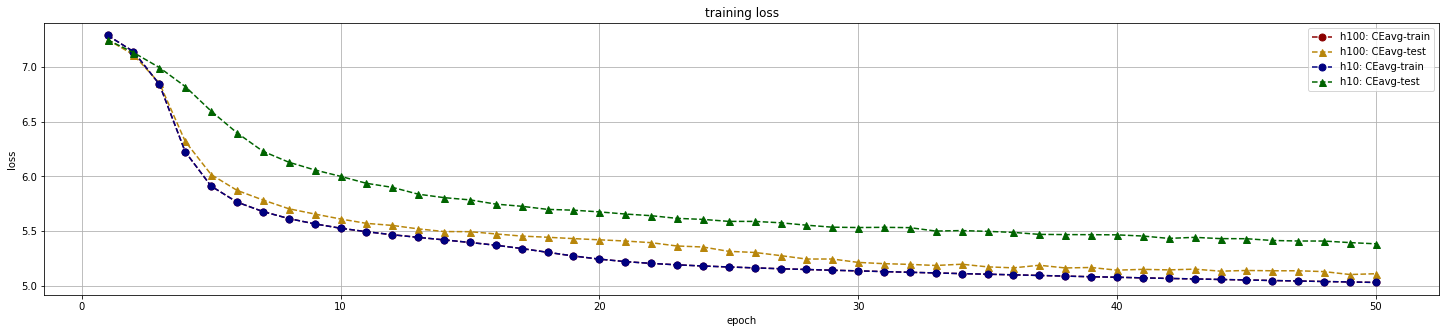

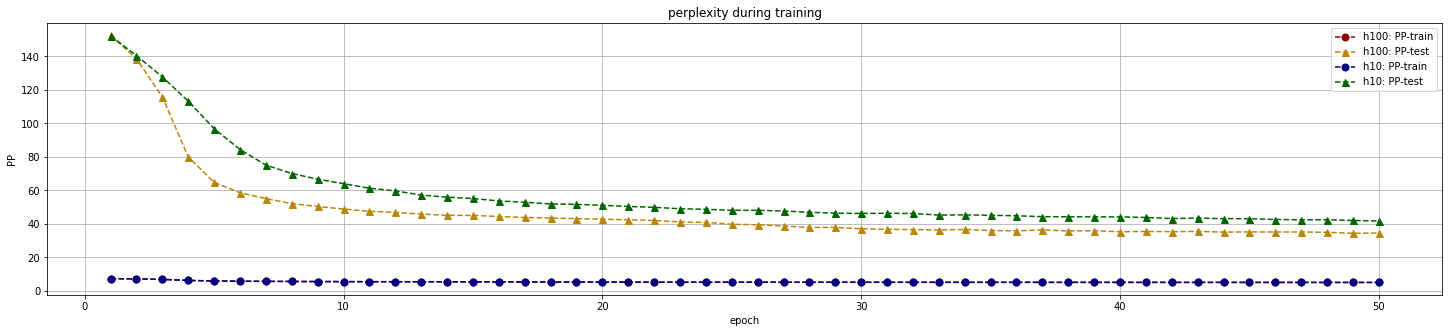

In [ ]:
params1 = {'LSTM_HIDEN_SIZE':10}
params2 = {'LSTM_HIDEN_SIZE':100}
model1, model2 = compare_two_models(params1, params2, 'h10', 'h100')

In [ ]:
generate_sentance(model1)

'she had lost part of walked very and saying . knew which men companion seek'

In [ ]:
generate_sentance(model2)

'she had lost part of england . </s>'

## train model - num layers

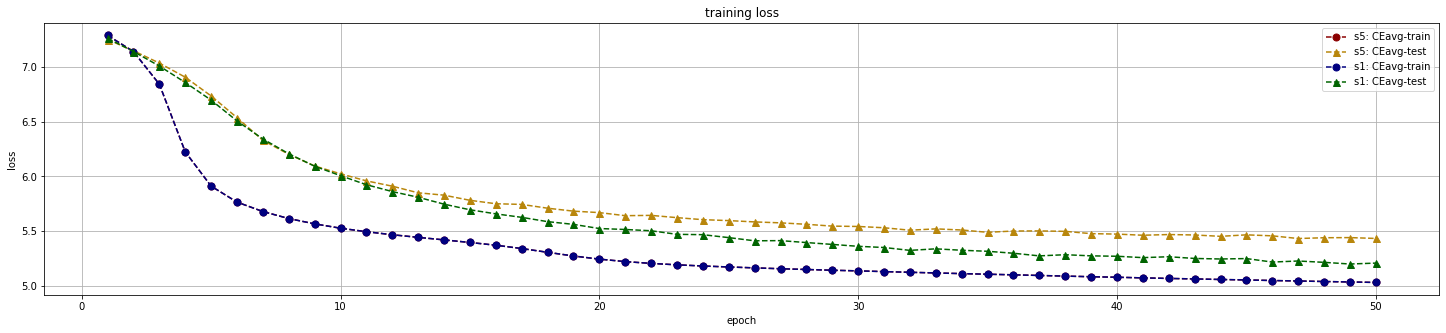

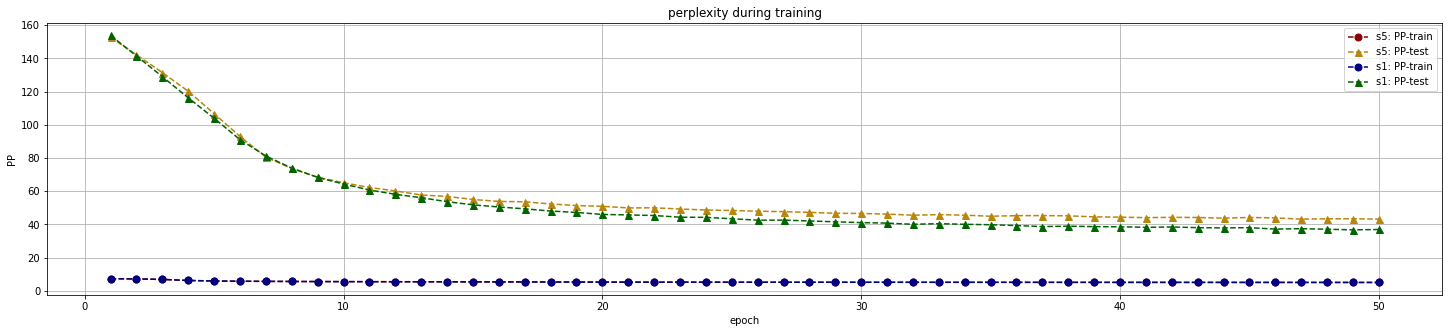

In [ ]:
params1 = {'NUM_LAYERS':1}
params2 = {'NUM_LAYERS':5}
model1, model2 = compare_two_models(params1, params2, 's1', 's5')

In [ ]:
generate_sentance(model1)

'she had lost part of glowing salt . there served rose touching police tied evening'

In [ ]:
generate_sentance(model2)

'she had lost part of yards perhaps as you the . her to people choice'

## train models - embeddin dim

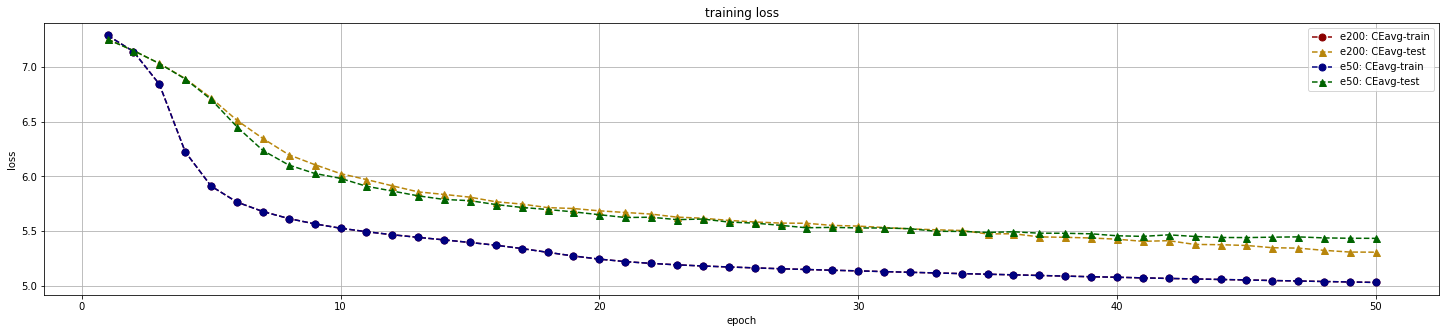

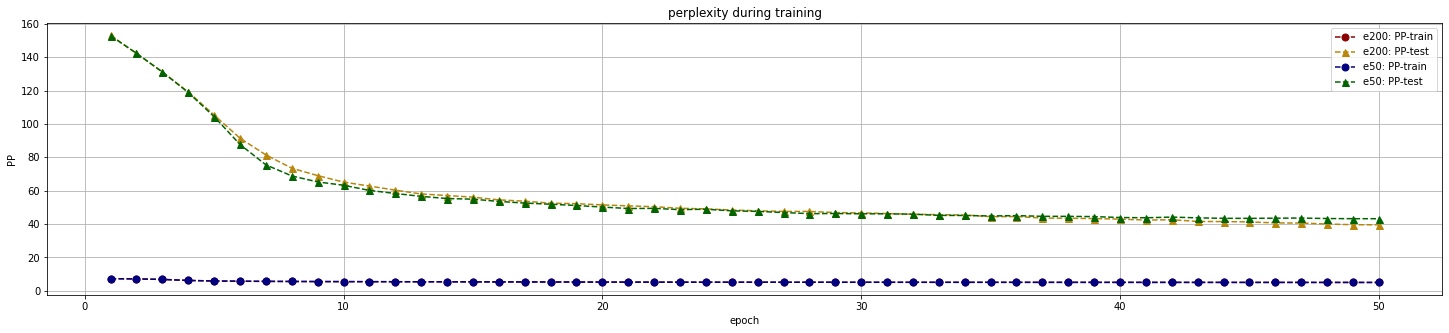

In [ ]:
params1 = {'EMBED_SIZE':50}
params2 = {'EMBED_SIZE':200}
model1, model2 = compare_two_models(params1, params2, 'e50', 'e200')

In [ ]:
generate_sentance(model1)

'she had lost part of truck for the distance walk food . of had watch'

In [ ]:
generate_sentance(model2)

'she had lost part of numbers out and reached self only the there agree it'

## train models - learning rate

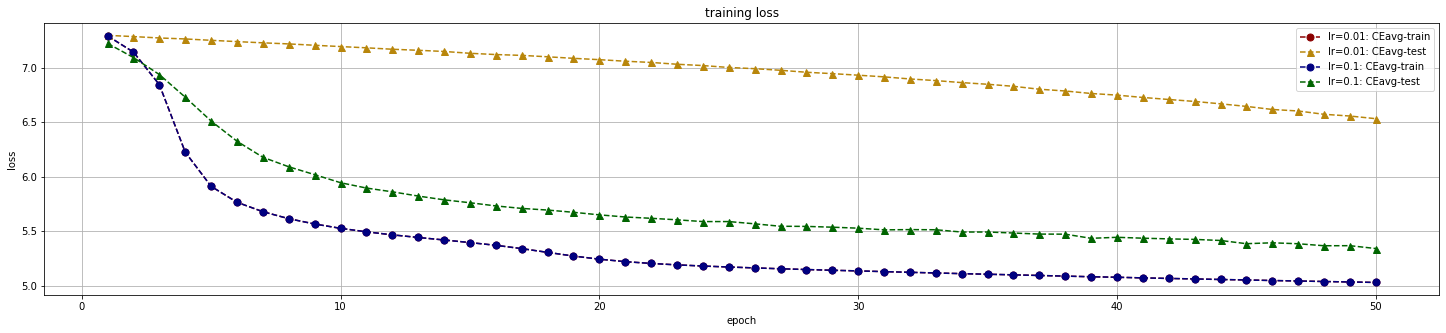

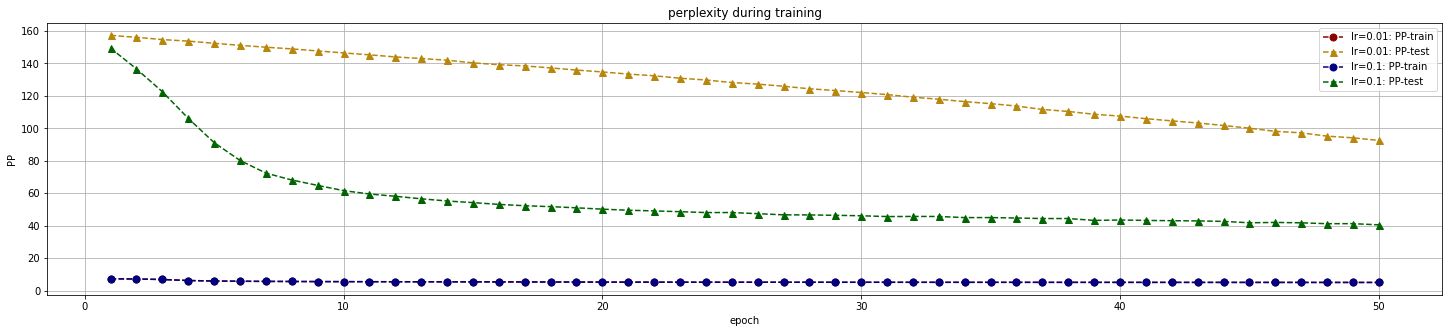

In [ ]:
params1 = {'LR':0.1}
params2 = {'LR':0.01}
model1, model2 = compare_two_models(params1, params2, 'lr=0.1', 'lr=0.01')

In [ ]:
generate_sentance(model1)

'she had lost part of other to your fella </s>'

In [ ]:
generate_sentance(model2)

'she had lost part of stephen lie fish watched to split waved . buck town'

# Writing Styles

In [ ]:
def visualize_model(loss_2, desc2=""):

    plt.figure(figsize=(25, 5))

    train_losses = loss_2

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc2+': CE-train', alpha=0.3, c='lightcoral')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='darkred', label = desc2+': CEavg-train', linestyle='--', marker='o', markersize=7)
    
    plt.title('loss during training')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(25, 5))

    train_losses = np.power(2,loss_2)

    x = np.linspace(0, EPOCHS, len(train_losses))
    # plt.plot(x, train_losses, label=desc2+': CE-train', alpha=0.3, c='lightcoral')
    train_losses_avg = [np.mean(np.array(train_losses[i*int(len(train_losses)/EPOCHS):(i+1)*int(len(train_losses)/EPOCHS)])) for i in range(EPOCHS)]
    plt.plot(range(1, EPOCHS+1), train_losses_avg, c='darkred', label = desc2+': PP-train', linestyle='--', marker='o', markersize=7)
    
    plt.title('perplexity training')
    plt.xlabel('epoch')
    plt.ylabel('PP')
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
def train(model, traindl, loss_function, optimizer, epochs, train_losses = None):
    if train_losses is None:
        train_losses = []
    for epoch in tqdm(range(epochs),desc='Epochs'):
        for X, Y, L in traindl:
            X = X.to(device)
            Y = Y.to(device)

            model.zero_grad()
            O = model(X, L)

            Y = Y.view((-1,))
            O = O.view(Y.shape[0], -1)

            loss = loss_function(O, Y)
            loss.backward()
            optimizer.step()

            # creat log
            train_losses.append(loss.item())

    return train_losses

In [ ]:
selected_book1 = 'crocodiles-spirit.epub.txt'
selected_book2 = 'zombies-bite.epub.txt'
selected_book3 = 'your-guide-to-succeed-after-graduation.epub.txt'
selected_book4 = 'towards-a-sacred-sexuality.epub.txt'

In [ ]:
with open(path+selected_book1) as f:
    book = f.read()
prep = MyPreprocessor()
prep.fit(book)

EMBED_SIZE      = 50
LSTM_HIDEN_SIZE = 100
NUM_LAYERS      = 2
NUM_VOCABS      = len(prep.dictionary)
PAD_IDX         = prep.dictionary.to_idx(SENT_PAD)
BATCH_SIZE      = 256
EPOCHS          = 50
LR              = 0.1

trainds = SentDS(prep.dictionary, prep.dictionary.words)
traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
model1   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
model1.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.SGD(model1.parameters(), lr=LR)
losses1 = train(model1,traindl,loss_function, optimizer, EPOCHS)

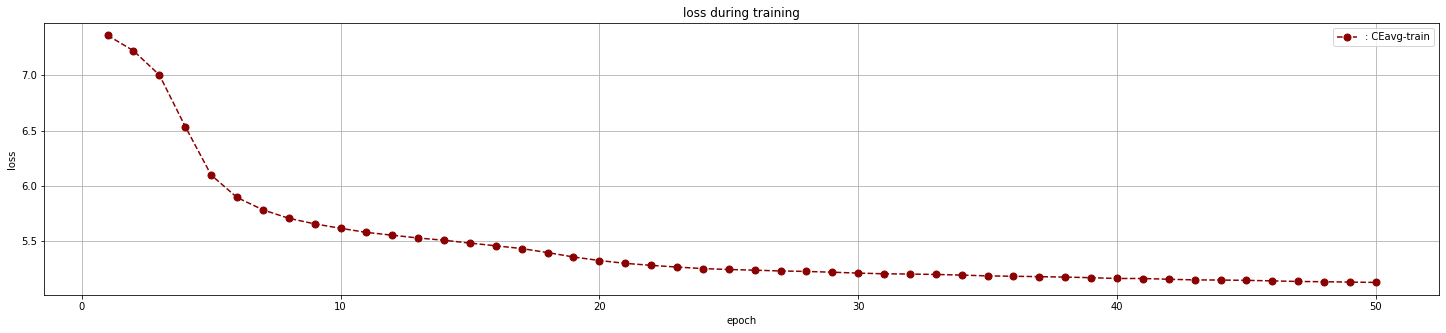

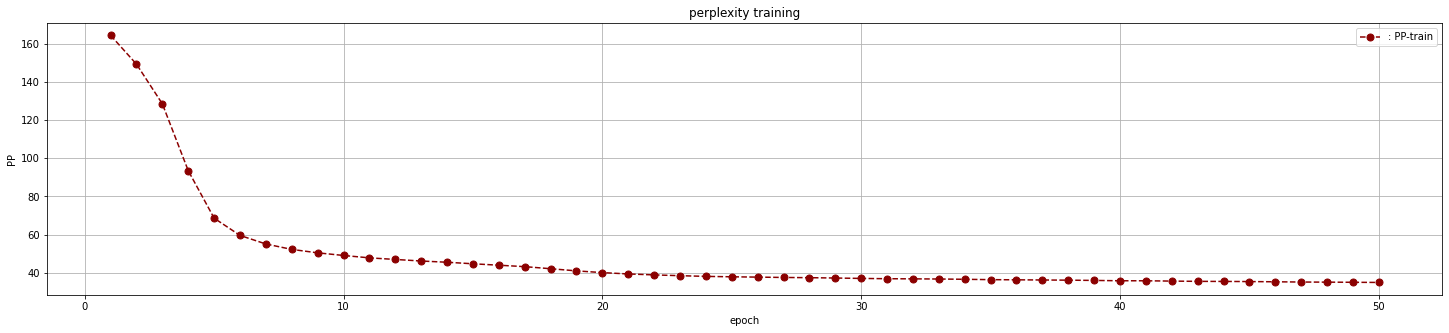

In [ ]:
visualize_model(losses1)

In [ ]:
generate_sentance(model1, [SENT_START])

'finding evidence in inside university his it . </s>'

In [ ]:
with open(path+selected_book2) as f:
    book = f.read()
prep = MyPreprocessor()
prep.fit(book)

EMBED_SIZE      = 50
LSTM_HIDEN_SIZE = 100
NUM_LAYERS      = 2
NUM_VOCABS      = len(prep.dictionary)
PAD_IDX         = prep.dictionary.to_idx(SENT_PAD)
BATCH_SIZE      = 256
EPOCHS          = 50
LR              = 0.1

trainds = SentDS(prep.dictionary, prep.dictionary.words)
traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
model2   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
model2.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.SGD(model2.parameters(), lr=LR)
losses2 = train(model2,traindl,loss_function, optimizer, EPOCHS)

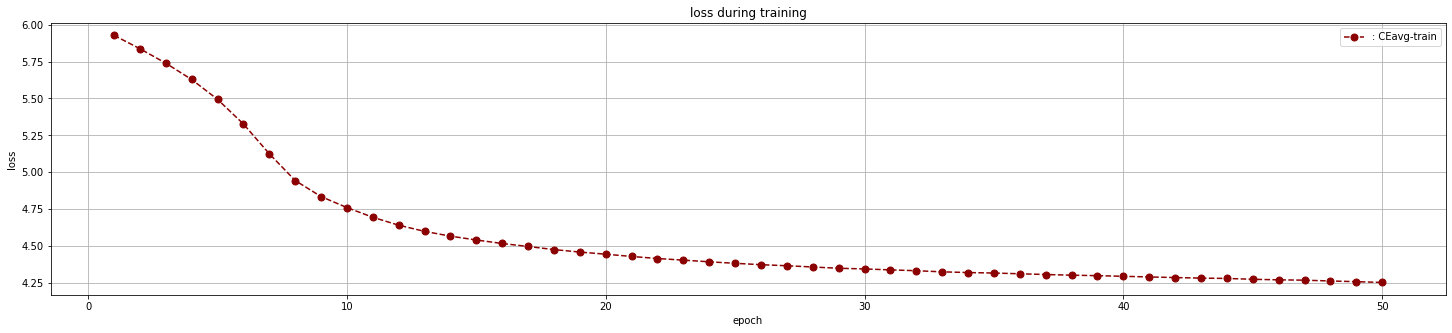

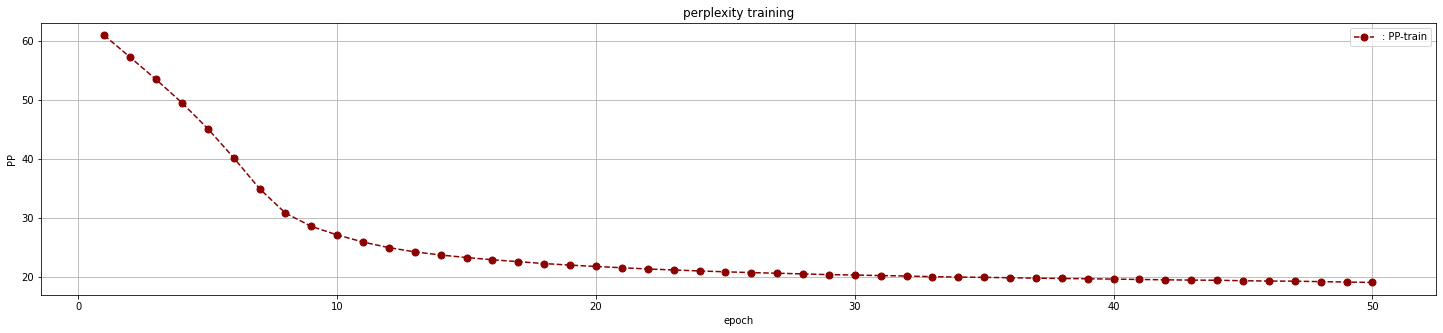

In [ ]:
visualize_model(losses2)

In [ ]:
generate_sentance(model2, [SENT_START])

'coming back over and my vamp a </s>'

In [ ]:
with open(path+selected_book3) as f:
    book = f.read()
prep = MyPreprocessor()
prep.fit(book)

EMBED_SIZE      = 50
LSTM_HIDEN_SIZE = 100
NUM_LAYERS      = 2
NUM_VOCABS      = len(prep.dictionary)
PAD_IDX         = prep.dictionary.to_idx(SENT_PAD)
BATCH_SIZE      = 256
EPOCHS          = 50
LR              = 0.1

trainds = SentDS(prep.dictionary, prep.dictionary.words)
traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
model3   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
model3.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.SGD(model3.parameters(), lr=LR)
losses3 = train(model3,traindl,loss_function, optimizer, EPOCHS)

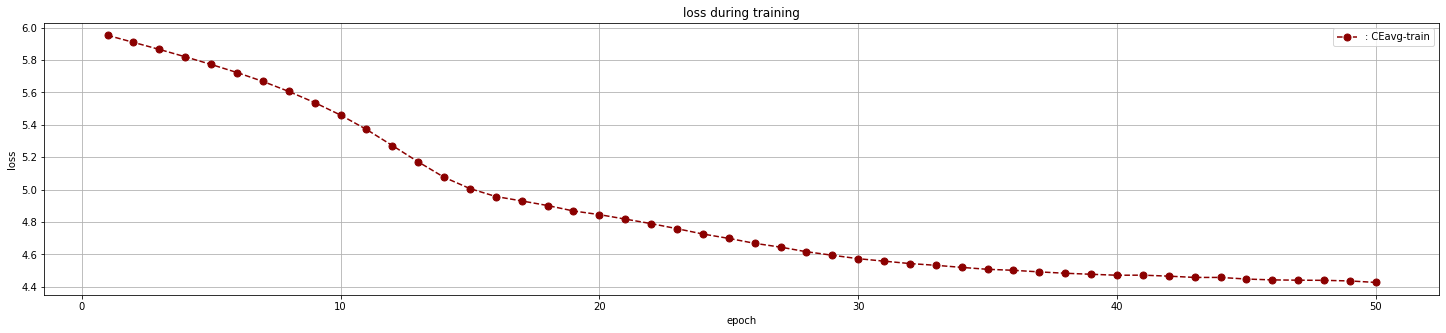

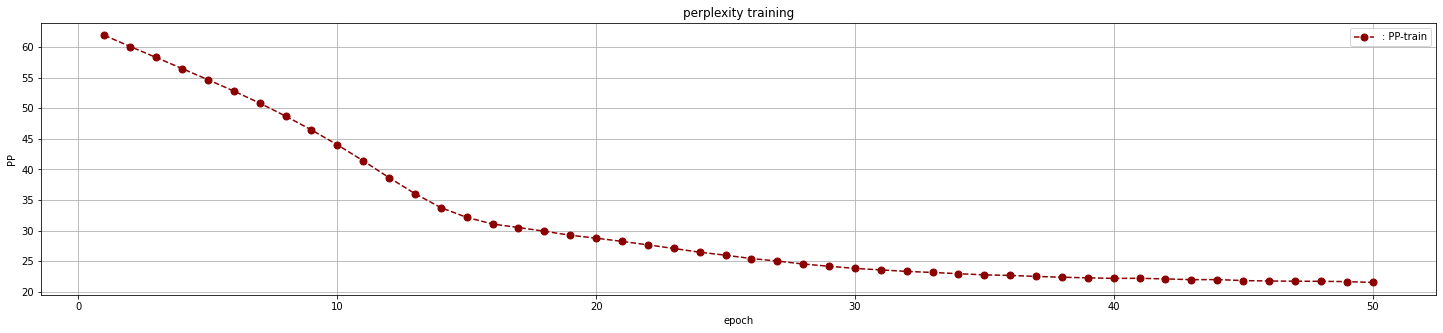

In [ ]:
visualize_model(losses3)

In [ ]:
generate_sentance(model3, [SENT_START])

'your professional provide idea </s>'

In [ ]:
with open(path+selected_book4) as f:
    book = f.read()
prep = MyPreprocessor()
prep.fit(book)

EMBED_SIZE      = 50
LSTM_HIDEN_SIZE = 100
NUM_LAYERS      = 2
NUM_VOCABS      = len(prep.dictionary)
PAD_IDX         = prep.dictionary.to_idx(SENT_PAD)
BATCH_SIZE      = 256
EPOCHS          = 50
LR              = 0.1

trainds = SentDS(prep.dictionary, prep.dictionary.words)
traindl = DataLoader(trainds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=0, collate_fn=pad_collate)
model4   = LSTMLM(EMBED_SIZE, LSTM_HIDEN_SIZE, NUM_LAYERS, NUM_VOCABS, PAD_IDX)
model4.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.SGD(model4.parameters(), lr=LR)
losses4 = train(model4,traindl,loss_function, optimizer, EPOCHS)

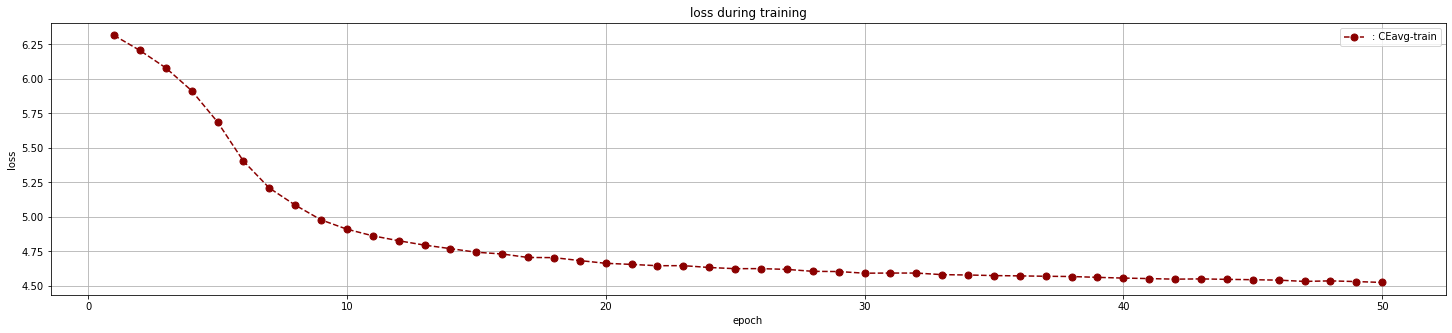

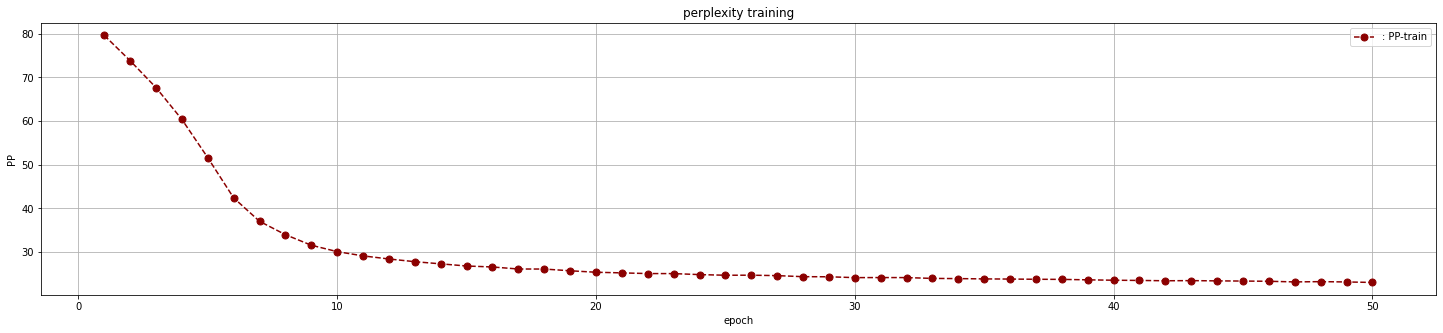

In [ ]:
visualize_model(losses4)

In [ ]:
generate_sentance(model4, [SENT_START])

'fact energy were a prison or solitary and of other feminine why you </s>'